This notebook aims at generating a MLP-type model (Multi-Layer Perceptron)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

2025-11-03 11:47:11.474912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training on data from September 15 to November 15, available at https://open-meteo.com/en/docs/historical-weather-api

Note : we changed the dataset because the model's predictions were biased towards low values, as its training window ended with cold data

In [2]:
file_path = './data/last_year.csv'

df = pd.read_csv(file_path)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8784 non-null   object 
 1   temperature  8784 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.4+ KB
None
               time  temperature
0  2024-10-10T00:00         13.9
1  2024-10-10T01:00         12.9
2  2024-10-10T02:00         13.0
3  2024-10-10T03:00         12.6
4  2024-10-10T04:00         12.5


Filter the data set

In [3]:
numeric_cols = ['temperature']
data_selected = df[numeric_cols]
data_selected.shape

(8784, 1)

We fetched hourly data but we needed it half-hourly, so we splitted it as follows :

|hour|°C|
|-|-|
|0|10|
|1|12|
|2|11|

Taking the average values :

|hour|°C|
|-|-|
|0|10|
|0.5|11|
|1|12|
|1.5|11.5|
|2|11|

In [4]:
expanded_data = []

for i in range(len(data_selected) - 1):
    # current value
    expanded_data.append(data_selected.iloc[i].values[0])
    
    # compute and add the average between current and next value
    avg = (data_selected.iloc[i].values[0] + data_selected.iloc[i + 1].values[0]) / 2
    expanded_data.append(avg)

# last value
expanded_data.append(data_selected.iloc[-1].values[0])

data_selected = pd.DataFrame({'temperature': expanded_data})

print(f"New data shape: {data_selected.shape}")
print(data_selected.head(10))

New data shape: (17567, 1)
   temperature
0        13.90
1        13.40
2        12.90
3        12.95
4        13.00
5        12.80
6        12.60
7        12.55
8        12.50
9        12.15


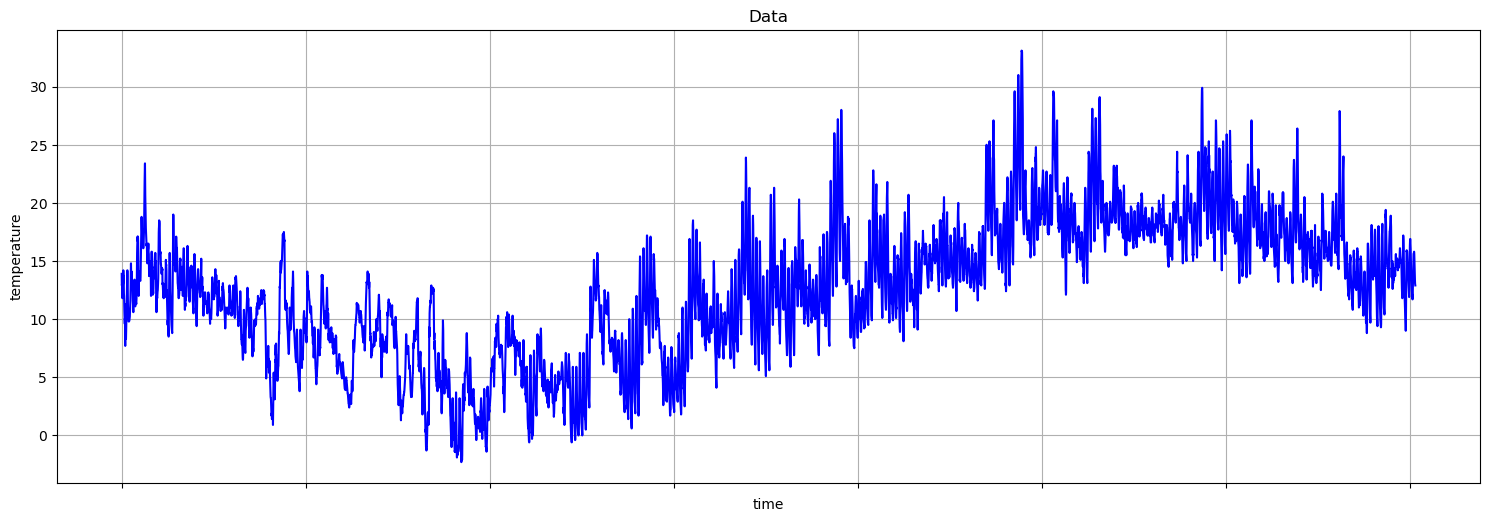

In [5]:
colors = ['blue', 'green']
n_features = len(colors)
plt.figure(figsize=(15, 10))

for i, (feature, color) in enumerate(zip(data_selected.columns, colors), 1):
    ax = plt.subplot(n_features, 1, i, sharex=ax if i > 1 else None)
    data_selected[feature].plot(ax=ax, color=color)
    ax.set_title("Data")
    ax.set_xlabel('time')
    ax.set_ylabel(feature)
    ax.grid(True)

    if i < n_features:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

Normalize data between 0 and 1

In [6]:
scaler = MinMaxScaler()
scaler.fit([[-5.0], [25.0]])  #here: min=-5°C, max=25°C # 60°   0.2 * 30 = 15 + -5 = 10°

data_scaled = scaler.fit_transform(data_selected)

Function to create inputs for our model

In [7]:
def create_sequences_1d(data, seq_length):
    X, y = [], []
    data = np.asarray(data).reshape(-1)  # ensure 1D
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y).reshape(-1, 1)

We choose `seq_length` = 48 * 30 min = 24h so that the LSTM can detect daily patterns.

In [8]:
seq_length = 48
X_all, y_all = create_sequences_1d(data_scaled.squeeze(), seq_length)

Split data into train test sets with a ratio of 85%

In [9]:
train_size = int(len(X_all) * 0.85)
X_train = X_all[:train_size]
y_train = y_all[:train_size]
X_test  = X_all[train_size:]
y_test  = y_all[train_size:]

Model is quite deep, we tried with several and this one stands out (see [this file](./compare_lstm.ipynb)).

In [10]:
%%capture

model = Sequential([
    Dense(32, activation='relu'   , input_shape=(seq_length,)),
    Dense(16, activation='relu'  ),
    Dense(8,  activation='relu'  ),
    Dense(1,  activation='linear')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='mse', metrics=['mae'])

2025-11-03 11:47:13.272948: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Check if the model is light enough for our nano 33

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

We train the model with an `EarlyStopping` in order to detect when training becomes counterproductive (if `val_loss` rises up, we restore the best weights obtained during training).

In [12]:
results = []

history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=300,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
    verbose=1
    )

Epoch 1/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - loss: 0.0045 - mae: 0.0325 - val_loss: 4.3218e-04 - val_mae: 0.0158
Epoch 2/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 3.4368e-04 - mae: 0.0143 - val_loss: 7.7669e-04 - val_mae: 0.0245
Epoch 3/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 2.5103e-04 - mae: 0.0122 - val_loss: 4.8231e-04 - val_mae: 0.0190
Epoch 4/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 2.1914e-04 - mae: 0.0114 - val_loss: 6.8221e-04 - val_mae: 0.0235
Epoch 5/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - loss: 1.8247e-04 - mae: 0.0103 - val_loss: 4.6327e-04 - val_mae: 0.0192
Epoch 6/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 1.6322e-04 - mae: 0.0098 - val_loss: 1.1323e-04 - val_mae: 0.0075
Epoch 7/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 1.4684e-04 - mae: 0.0093 - val_loss: 8.0625e-04 - val_mae: 0.0268
Epoch 8/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 1.3606e-04 - mae: 0.0089 - val_loss: 1

In [13]:
test_loss, test_mae = model.evaluate(X_test, y_test)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 4.5773e-05 - mae: 0.0047


Print training history

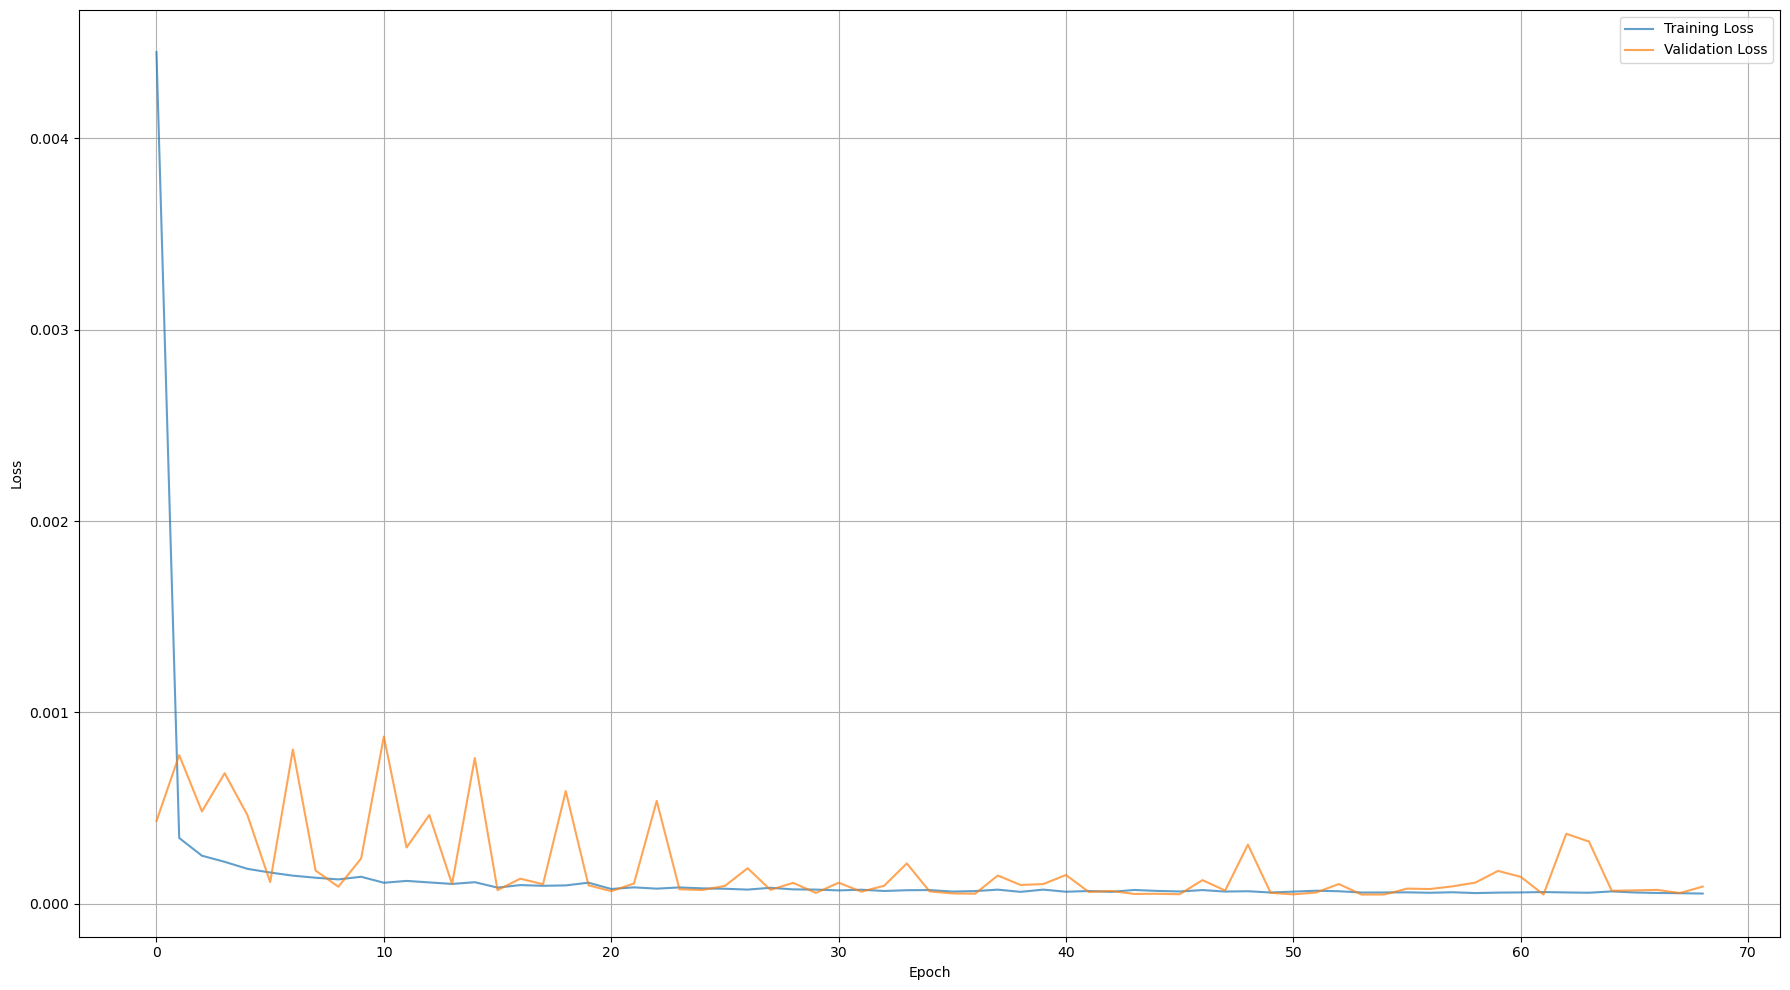

In [14]:
plt.figure(figsize=(18, 10))

plt.plot(history.history['loss'], label='Training Loss', alpha=0.7)
plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.7)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import r2_score

# Make predictions on test set
y_pred = model.predict(X_test, verbose=0)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

R² Score: 0.9944
Test Loss (MSE): 0.000046
Test MAE: 0.004693


Recursive predictions function : the model feeds with its own last output to predict the next value

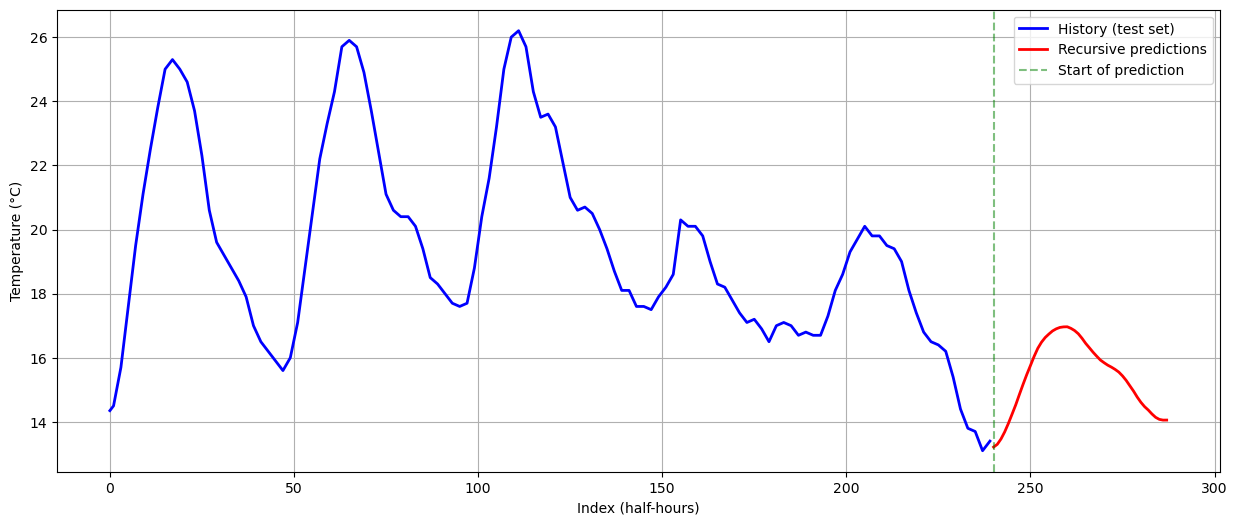

[16.7  16.7  17.   17.3  17.7  18.1  18.35 18.6  18.95 19.3  19.5  19.7
 19.9  20.1  19.95 19.8  19.8  19.8  19.65 19.5  19.45 19.4  19.2  19.
 18.55 18.1  17.75 17.4  17.1  16.8  16.65 16.5  16.45 16.4  16.3  16.2
 15.8  15.4  14.9  14.4  14.1  13.8  13.75 13.7  13.4  13.1  13.25 13.4 ]


In [16]:
def predict_recursive(model, initial_sequence, n_steps, scaler):
    current_seq = initial_sequence.copy().flatten()
    predictions = []
    
    for _ in range(n_steps):
        current_input = current_seq.reshape(1, -1)
        next_pred = model.predict(current_input, verbose=0)[0, 0]
        predictions.append(next_pred)
        current_seq = np.append(current_seq[1:], next_pred)
    
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_denorm = scaler.inverse_transform(predictions).flatten()
    
    return predictions_denorm

n_history = min(240, len(X_test))
last_values = X_test[:n_history]
last_denorm = scaler.inverse_transform(last_values).flatten()

# start recursive prediction after the displayed values
start_recursive_idx = n_history - 1  # Take the last sequence displayed
initial_sequence = X_test[start_recursive_idx]

n_steps = 48
recursive_pred = predict_recursive(model, initial_sequence, n_steps, scaler)

# Display
plt.figure(figsize=(15, 6))
# Extract the last value from each sequence to create a continuous line
last_denorm_plot = scaler.inverse_transform(y_test[:n_history]).flatten()
plt.plot(range(n_history), last_denorm_plot, 'b-', label='History (test set)', linewidth=2)
plt.plot(range(n_history, n_history + len(recursive_pred)), recursive_pred, 'r-', label='Recursive predictions', linewidth=2)
plt.axvline(x=n_history, color='green', linestyle='--', alpha=0.5, label='Start of prediction')
plt.xlabel('Index (half-hours)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

print(last_denorm_plot[-48:])
# print(f"Dernière valeur historique: {last_denorm[-1]:.2f}°C")
# print(f"Première prédiction: {recursive_pred[0]:.2f}°C")
# print(recursive_pred)

We can use the file [eval_model.ipynb](eval_model.ipynb) to evaluate the model.

Save the model

In [17]:
model.save('./models/MLP/mlp_temperature_model.keras')     # .keras (native Keras format)
model.save('./models/MLP/mlp_temperature_model.h5')        # HDF5 (just in case)

for i, feat in enumerate(numeric_cols):
    print(f"{feat} -> data_min: {scaler.data_min_[i]}, data_max: {scaler.data_max_[i]}, data_range: {scaler.data_range_[i]}")
    print(f"{feat} -> min_: {scaler.min_[i]}, scale_: {scaler.scale_[i]}\n")

print(f"seq_length: {seq_length}")

temperature -> data_min: -2.3, data_max: 33.1, data_range: 35.4
temperature -> min_: 0.06497175141242938, scale_: 0.02824858757062147

seq_length: 48
